# Unsupervised Analysis of Days of Week

Treating crossing each day as features to learn about the relatinships between various days.

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Downloading Data

We'll start by downloading the data (available on [seattle.gov](http://www.seattle.gov/transportation/bikecounter_fremont.htm)).

## Group Operations

In [39]:
import os
from urllib.request import urlretrieve

import pandas as pd

FREMONT_URL = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'

def get_fremont_data(filename='Fremont.csv', url=FREMONT_URL,
                     force_download=False):
    """ Download and Cache the Fremont Data

    Parameters
    -------------
    filename : string (optional)
         location to save the data
    url : string (optional)
         web location of the data
    force_download : bool (optional)
         if true, force redownload of data

    Returns
    =====
    data : pandas.DataFrame
            The fremont bridge data
    """
    if force_download or not os.path.exists(filename):
        urlretrieve(url, filename)

    data = pd.read_csv('Fremont.csv', index_col='Date')
    try:
        data.index = pd.to_datetime(data.index, format='%m/%d/%Y %I:%M:%S %p')
    except TypeError:
        data.index = pd.to_datetime(data.index)            
    # data = pd.read_csv('Fremont.csv', index_col='Date', parse_dates=True)
    data.columns = ['West', 'East']
    data['Total'] = data['West'] + data['East']
    return data

## Get Data

In [40]:
data = get_fremont_data()
data.head()

,West,East,Total
Date,,,
2012-10-03 00:00:00,4.0,9.0,13.0
2012-10-03 01:00:00,4.0,6.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,2.0,3.0,5.0
2012-10-03 04:00:00,6.0,1.0,7.0


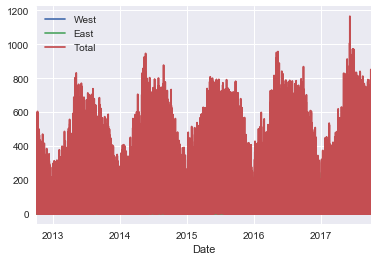

In [41]:
data.plot()

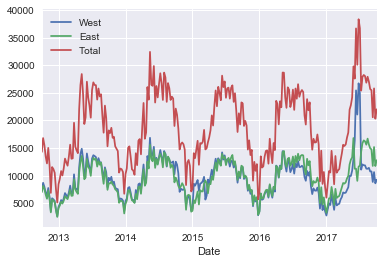

In [58]:
data.resample('w').sum().plot()

(0, 1059460.05)

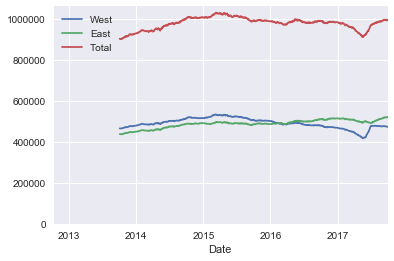

In [43]:
ax = data.resample('D').sum().rolling(365).sum().plot()
ax.set_ylim(0, None)

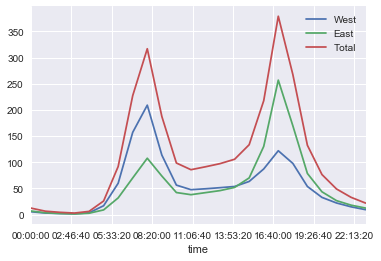

In [44]:
data.groupby(data.index.time).mean().plot()

In [45]:
pivoted = data.pivot_table('Total', index=data.index.time, columns=data.index.date)
pivoted.iloc[:5, :5]

,2012-10-03,2012-10-04,2012-10-05,2012-10-06,2012-10-07
00:00:00,13.0,18.0,11.0,15.0,11.0
01:00:00,10.0,3.0,8.0,15.0,17.0
02:00:00,2.0,9.0,7.0,9.0,3.0
03:00:00,5.0,3.0,4.0,3.0,6.0
04:00:00,7.0,8.0,9.0,5.0,3.0


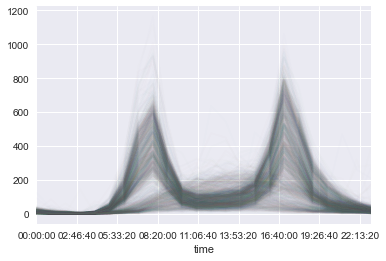

In [46]:
pivoted.plot(legend=False, alpha=0.01)

## Principal Component Analysis

In [47]:
X = pivoted.fillna(0).T.values
X.shape

(1824, 24)

In [48]:
from sklearn.decomposition import PCA

X2 = PCA(2, svd_solver='full').fit_transform(X)

In [49]:
X2.shape

(1824, 2)

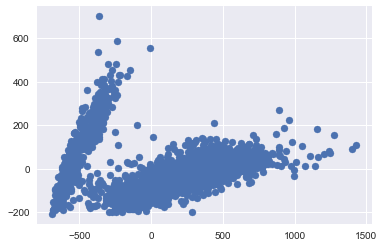

In [50]:
plt.scatter(X2[:, 0], X2[:, 1])

## Unsupervised Clustering

In [51]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(2)
gmm.fit(X)
labels = gmm.predict(X)
labels


array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

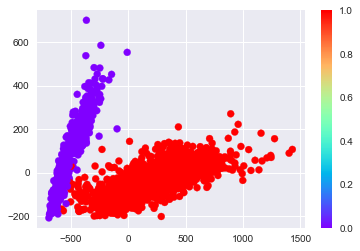

In [52]:
plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='rainbow')
plt.colorbar()

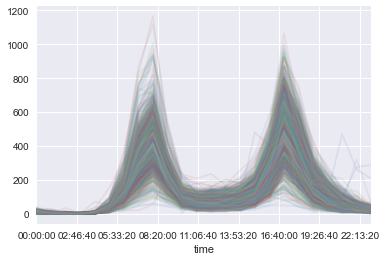

In [53]:
pivoted.T[labels == 1].T.plot(legend=False, alpha=0.1)

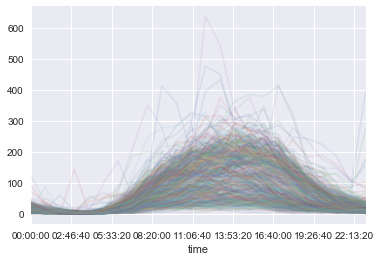

In [54]:
pivoted.T[labels == 0].T.plot(legend=False, alpha=0.1)

## Comparing with Day of Week

In [55]:
dayofweek = pd.DatetimeIndex(pivoted.columns).dayofweek

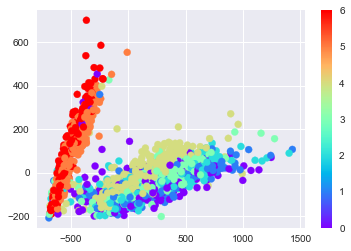

In [56]:
plt.scatter(X2[:, 0], X2[:, 1], c=dayofweek, cmap='rainbow')
plt.colorbar()

## Analyzing Outliers

The following points are weekdays with a holiday-like pattern.

In [57]:
dates = pd.DatetimeIndex(pivoted.columns)
dates[(labels == 0) & (dayofweek < 5)]

DatetimeIndex(['2012-11-22', '2012-11-23', '2012-12-24', '2012-12-25',
               '2013-01-01', '2013-05-27', '2013-07-04', '2013-07-05',
               '2013-09-02', '2013-11-28', '2013-11-29', '2013-12-20',
               '2013-12-24', '2013-12-25', '2014-01-01', '2014-04-23',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-11-27',
               '2014-11-28', '2014-12-24', '2014-12-25', '2014-12-26',
               '2015-01-01', '2015-05-25', '2015-07-03', '2015-09-07',
               '2015-11-26', '2015-11-27', '2015-12-24', '2015-12-25',
               '2016-01-01', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-11-24', '2016-11-25', '2016-12-26', '2017-01-02',
               '2017-02-06', '2017-05-29', '2017-07-04', '2017-09-04'],
              dtype='datetime64[ns]', freq=None)

What's up with Feb 6, 2017?

[Snow Storm](https://www.seattletimes.com/seattle-news/weather/weather-service-predicts-3-to-6-inches-of-snow-in-seattle-area/)